# **Install Required Libraries**

In [1]:
!pip install ultralytics torch torchvision matplotlib pillow opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.3/886.3 kB 18.2 MB/s eta 0:00:00


# **Clone and setup SAM2 repo**

In [2]:
!pip install iopath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=92745b626a159d4ec8dd3e744fd5d8379e19ffeaf6e2c39f399f7c3c8e068d56
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath


In [3]:
!pip install hydra-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.9 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=8a132b27598a7ddbb5026acef7313d11e9354e7bd6fd86502b02c2368ffc73a5
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [1]:
!git clone https://github.com/facebookresearch/sam2.git

Cloning into 'sam2'...
remote: Enumerating objects: 974, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 974 (delta 17), reused 18 (delta 6), pack-reused 936 (from 1)
Receiving objects: 100% (974/974), 128.94 MiB | 13.18 MiB/s, done.
Resolving deltas: 100% (334/334), done.


In [2]:
cd /content/sam2

/content/sam2


# **Import Libraries**

In [16]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import cv2

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


# **Load the YOLO Model**

In [4]:
model = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:00<00:00, 98.8MB/s]


# **Load Image for inference**

In [17]:
# Load an image from Google Drive
image_path = "/content/sam2_test.jpeg"
image = cv2.imread('/content/sam2_test.jpeg')
image_rsz = cv2.resize(image, (640, 640))
# image = np.array(image.convert("RGB"))


# **Perform Object Detection with YOLO**


0: 640x640 1 car, 85.8ms
Speed: 2.5ms preprocess, 85.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


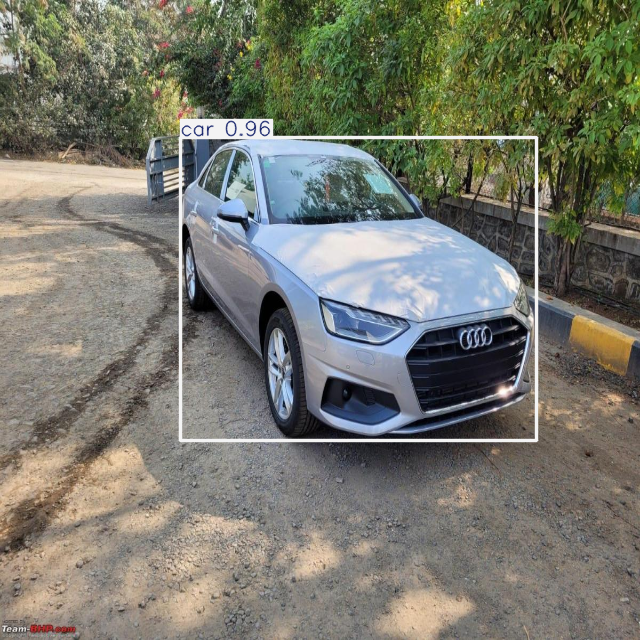

In [18]:
# Predict bounding boxes
results = model.predict(image_rsz, classes=[2.0])  # Specify the class you want
boxes = results[0].boxes.xyxy.tolist()
cv2_imshow(results[0].plot())
# Enable PyTorch mixed precision for compatible GPUs
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.is_available() and torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# **Define Visualization Functions**

In [7]:
def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()


In [8]:
!wget -P /content/sam2/checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt


--2024-11-16 10:25:01--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.124, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898083611 (856M) [application/vnd.snesdev-page-table]
Saving to: ‘/content/sam2/checkpoints/sam2.1_hiera_large.pt’

sam2.1_hiera_large. 100%[===================>] 856.48M   263MB/s    in 3.3s    

2024-11-16 10:25:04 (263 MB/s) - ‘/content/sam2/checkpoints/sam2.1_hiera_large.pt’ saved [898083611/898083611]



# **Build the SAM2 Model**

In [9]:
sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)

# **Predict from YOLO and Visualize Masks via SAM2**
Instead of manually specifying a point for SAM2 segmentation, we send the bounding box data from YOLO and it will automatically segment the object found in that box.

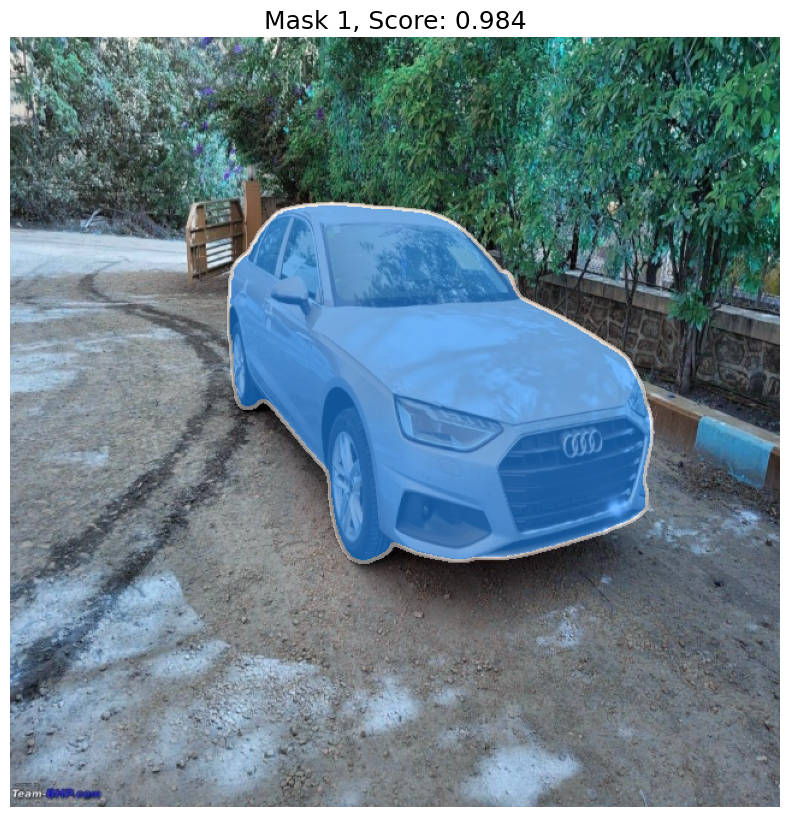

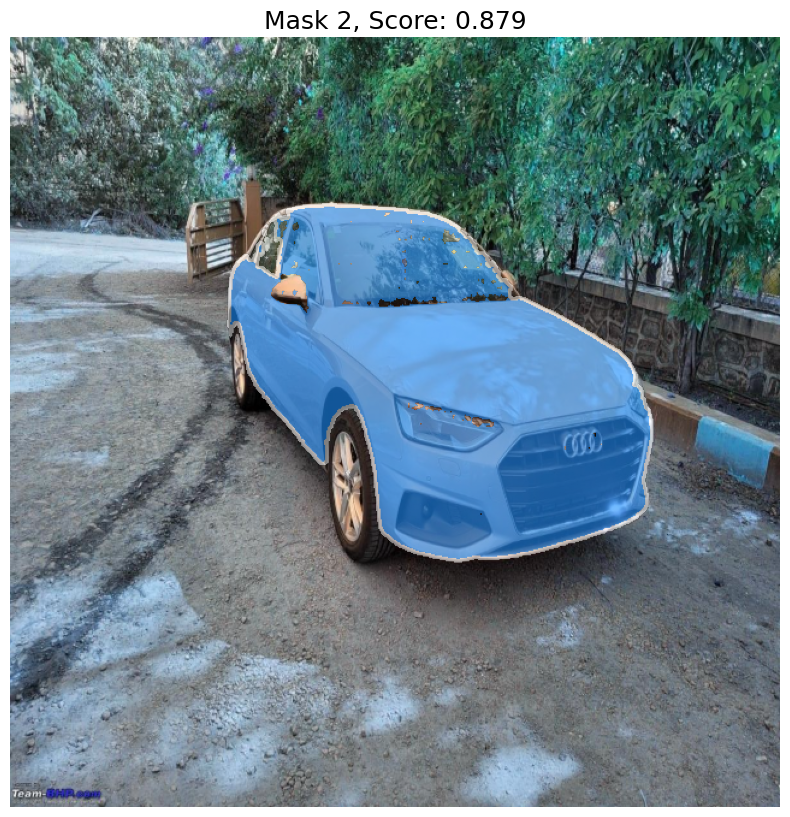

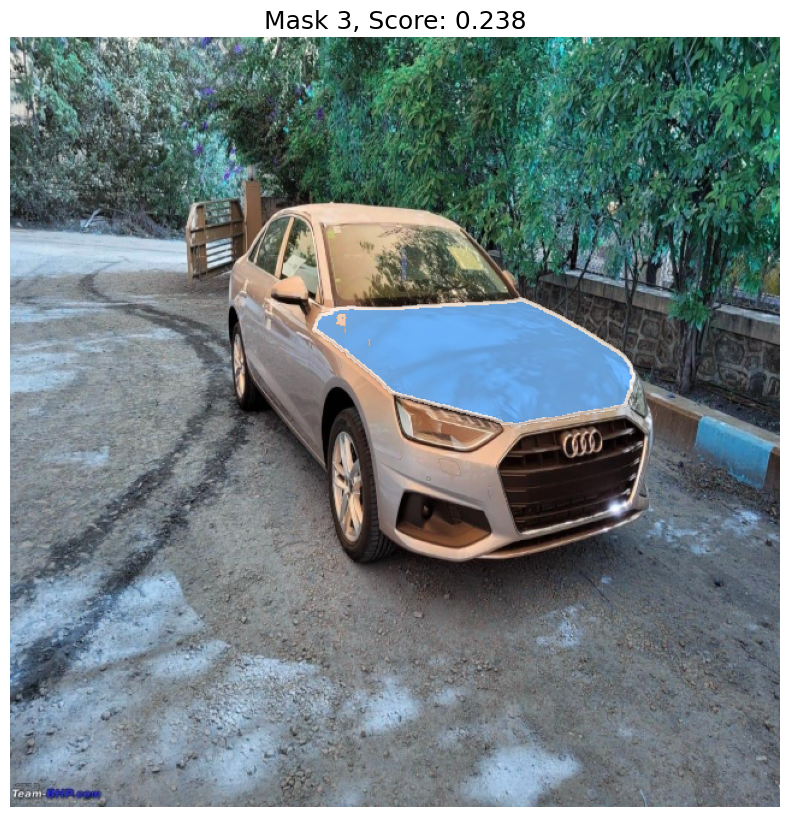

In [21]:
# Set the image for the predictor
predictor.set_image(image_rsz)

# Prepare bounding boxes and masks
input_boxes = []
for box in boxes:
    x1, y1, x2, y2 = box
    input_boxes.append(np.array([x1, y1, x2, y2]))

if len(input_boxes) > 1:
    masks, scores, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rsz)
    for mask in masks:
        show_mask(mask.squeeze(0), plt.gca(), random_color=True)
    for box in input_boxes:
        show_box(box, plt.gca())
    plt.axis('off')
    plt.show()
elif len(input_boxes) == 1:
    x1, y1, x2, y2 = input_boxes[0]
    input_box = np.array([x1, y1, x2, y2])
    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
    input_point = np.array([[xm, ym]])
    input_label = np.array([1])
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    show_masks(image_rsz, masks, scores, point_coords=input_point, input_labels=input_label)


# **Creating a polygon for the mask with the highest probability**

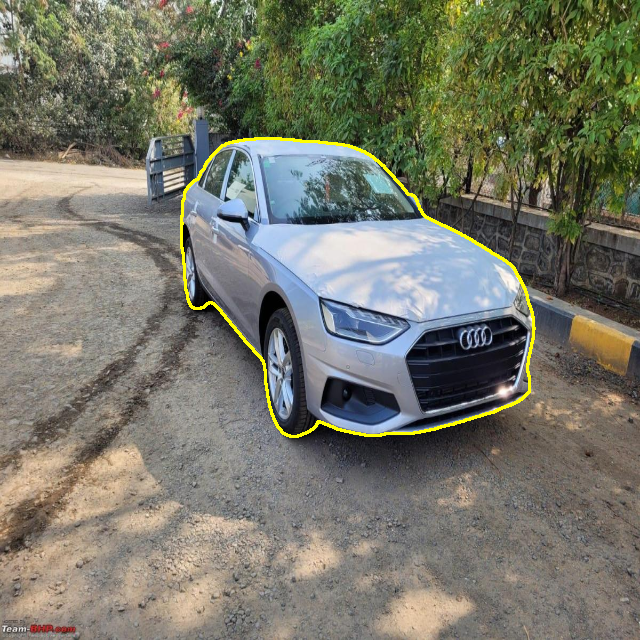

-1

In [24]:
mask = masks[0]
contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    polyimg = cv2.polylines(image_rsz, pts=[cnt], color=(0, 255, 255), isClosed=True, thickness=2)
cv2_imshow(polyimg)

# **Creating coordinates for YOLOv8 compatible dataset.**

In [27]:
flattened_array = contours[0].flatten()
# Normalize the values
max_value = 640   # YOLO ideally expects 640*640 image for training
normalized_array = flattened_array / max_value

# # Convert the normalized array to space-separated string
normalized_string = ' '.join(map(str, normalized_array))

# **Save the string to a .txt**
In this way, the YOLOv8 model will automatically call sam2 and create a segmentation dataset file for this image. So, you can convert your Bounding Box data automatically to YOLO Instance Segmenation format without needing to manually annotate the image points for segmentation.

In [26]:
normalized_string

'0.3984375 0.215625 0.396875 0.2171875 0.38125 0.2171875 0.3796875 0.21875 0.371875 0.21875 0.3703125 0.2203125 0.3640625 0.2203125 0.3625 0.221875 0.3578125 0.221875 0.35625 0.2234375 0.353125 0.2234375 0.35 0.2265625 0.346875 0.2265625 0.328125 0.2453125 0.328125 0.246875 0.321875 0.253125 0.321875 0.2546875 0.3203125 0.25625 0.3203125 0.2578125 0.31875 0.259375 0.31875 0.2625 0.315625 0.265625 0.3140625 0.265625 0.3140625 0.2671875 0.3125 0.26875 0.3125 0.271875 0.3109375 0.2734375 0.3109375 0.275 0.309375 0.2765625 0.309375 0.278125 0.3078125 0.2796875 0.30625 0.2796875 0.3046875 0.28125 0.303125 0.28125 0.2921875 0.2921875 0.2921875 0.29375 0.2890625 0.296875 0.2890625 0.2984375 0.2875 0.3 0.2875 0.309375 0.2859375 0.3109375 0.2859375 0.3125 0.284375 0.3140625 0.284375 0.3359375 0.2828125 0.3375 0.2828125 0.346875 0.284375 0.3484375 0.2828125 0.35 0.2828125 0.3859375 0.284375 0.3875 0.284375 0.39375 0.2859375 0.3953125 0.2859375 0.4109375 0.2875 0.4125 0.2875 0.4359375 0.2890625 0